In [49]:
import numpy, scipy, matplotlib.pyplot as plt, pandas, librosa, mir_eval
import IPython.display, IPython.html.widgets

[&larr; Back to Index](index.html)

# Beat Tracking

## `librosa.beat.beat_track`

Download an audio file:

In [50]:
import urllib
urllib.urlretrieve('http://audio.musicinformationretrieval.com/1_bar_funk_groove.mp3', 
                    filename='1_bar_funk_groove.mp3')

('1_bar_funk_groove.mp3', <httplib.HTTPMessage instance at 0x114840170>)

Read the file:

In [65]:
x, fs = librosa.load('1_bar_funk_groove.mp3')
print fs

22050


Use [`librosa.beat.beat_track`](http://bmcfee.github.io/librosa/generated/librosa.beat.beat_track.html#librosa.beat.beat_track) to estimate the beat locations and the global tempo:

In [52]:
tempo, beat_frames = librosa.beat.beat_track(x, fs, start_bpm=60)
print tempo
print beat_frames

56.1735733696
[ 47  92 138 184 231 275 321 366 412 459 504 550 595 641]


Plot the beat locations over the waveform:

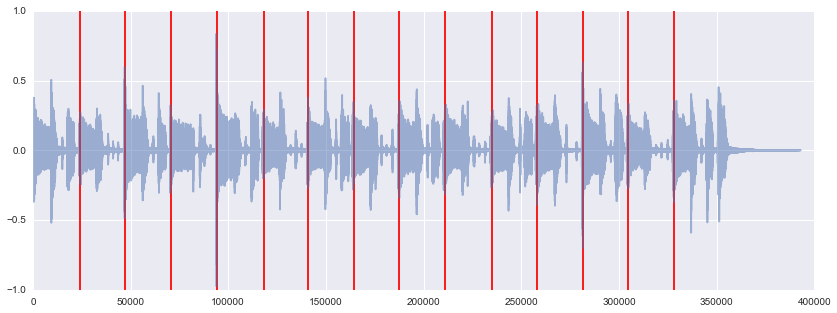

In [53]:
def plot_beats(beat_frames):
    plt.rcParams['figure.figsize'] = (14,5)
    plt.figure()
    plt.plot(x, alpha=0.5)
    beat_samples = librosa.frames_to_samples(beat_frames)
    plt.vlines(beat_samples, -1, 1, color='r')
plot_beats(beat_frames)

Plot a histogram of the intervals between adjacent beats:

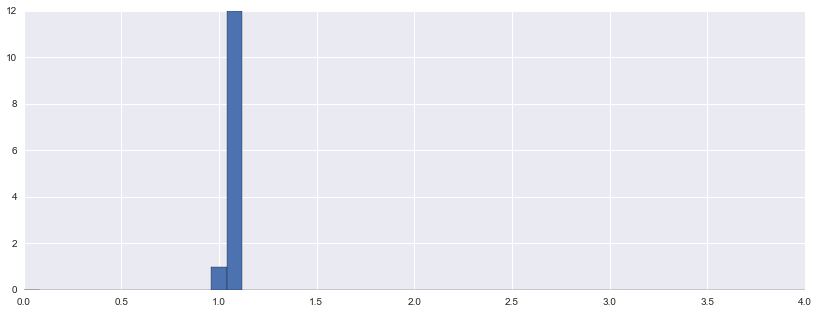

In [54]:
def plot_beat_histogram(beat_frames):
    beat_times = librosa.frames_to_time(beat_frames)
    beat_times_diff = numpy.diff(beat_times)
    plt.figure()
    plt.hist(beat_times_diff, bins=50, range=(0,4))
plot_beat_histogram(beat_frames)

Visually, it's difficult to tell how correct the estimated beats are. Let's listen to a click track:

In [55]:
def sonify_beats(beat_frames):
    beat_times = librosa.frames_to_time(beat_frames)
    clicks = mir_eval.sonify.clicks(beat_times, fs, length=len(x))
    return IPython.display.Audio(x + clicks, rate=fs)
sonify_beats(beat_frames)

Use the IPython interactive widgets to observe how the output changes as we vary the parameters of the beat tracker:

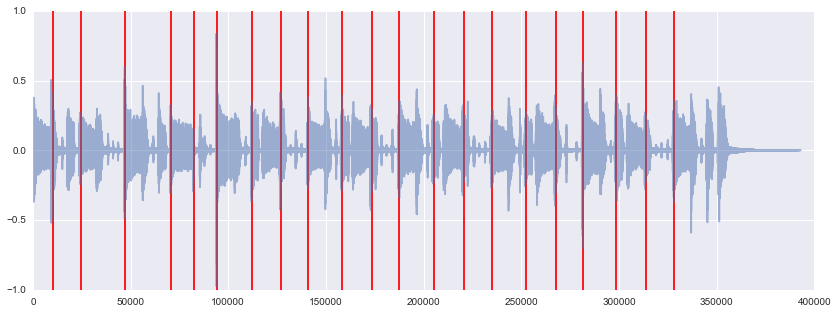

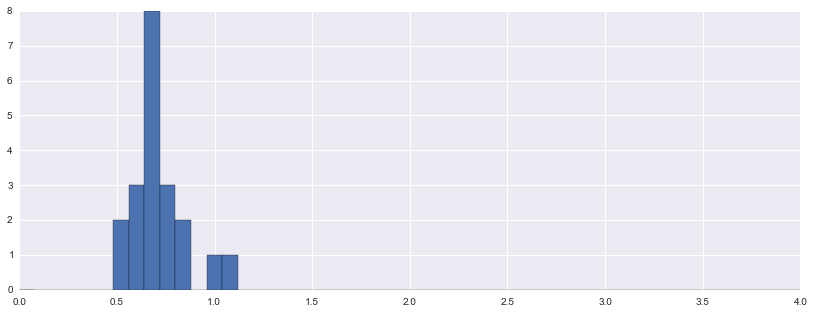

In [56]:
@IPython.html.widgets.interact(start_bpm=(30, 180, 20), tightness_exp=(-1, 3, 0.5))
def interact_f(start_bpm=60, tightness_exp=0):
    tempo, beat_frames = librosa.beat.beat_track(x, fs, start_bpm=start_bpm, tightness=10**tightness_exp)
    plot_beats(beat_frames)
    plot_beat_histogram(beat_frames)
    IPython.display.display(sonify_beats(beat_frames))

## `essentia.standard.RhythmExtractor2013`

Here's how to do beat tracking using Essentia.

Basic imports and settings:

In [57]:
import essentia.standard as ess
import essentia

Load a signal:

In [58]:
x = ess.MonoLoader(filename='1_bar_funk_groove.mp3')()
fs = 44100
print x.shape

(789120,)


The Essentia algorithm that we'll use is called [RhythmExtractor2013](http://essentia.upf.edu/documentation/reference/std_RhythmExtractor2013.html).

In [59]:
avg_bpm, beat_start, confidence, tempo, beat_duration = ess.RhythmExtractor2013(method='multifeature')(x)

Tempo in average beats per minute (BPM):

In [60]:
avg_bpm

112.17662811279297

Plot the signal along with the locations of each estimated beat:

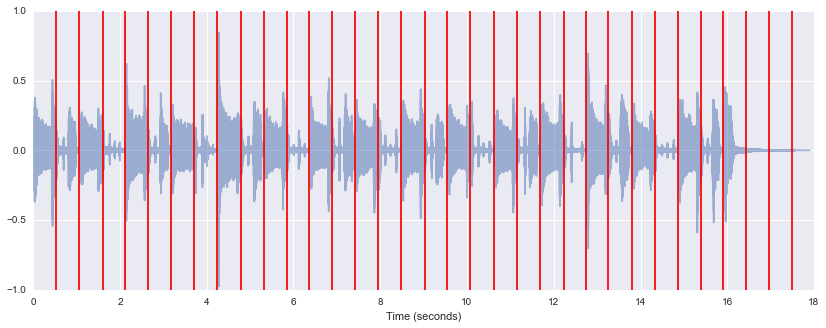

In [61]:
t = numpy.arange(len(x))/float(fs)
plt.plot(t, x, alpha=0.5)
plt.xlabel('Time (seconds)')
for t0 in beat_start:
    plt.axvline(t0, color='r')

Add a beep to each beat:

In [62]:
onsets_marker = ess.AudioOnsetsMarker(onsets=beat_start, type='beep')
x_beeps = onsets_marker(x)

Listen to the beats:

In [63]:
IPython.display.Audio(x_beeps, rate=fs)

Plot the tempo vs. time:

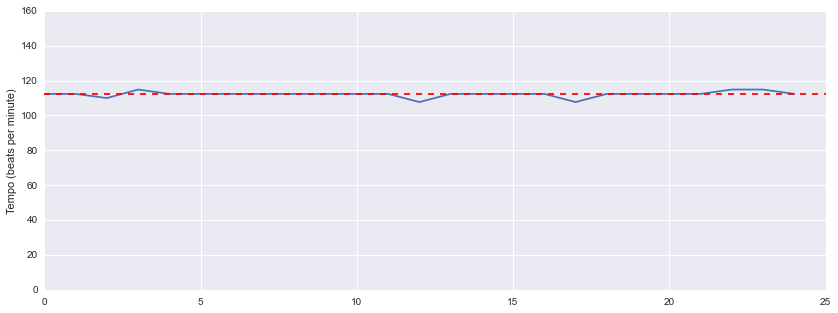

In [64]:
plt.plot(tempo)
plt.axhline(avg_bpm, color='r', linestyle='--')
plt.ylim(0, 160)
plt.ylabel('Tempo (beats per minute)')

[&larr; Back to Index](index.html)